## Objective:
Create relationship between the Cabin study data and segments and/or water bodies.

In [7]:
import geopandas as gpd
import pandas as pd
import fiona
# from ipyfilechooser import FileChooser
from geopandas import GeoSeries

import itertools
from operator import itemgetter

import numpy as np

from scipy.spatial import cKDTree

from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString


## Steps:
- Convert lon and lot from Cabin data to Points
- Use the two functions in `Barrier-Waterbody-segments-connection` file
- Find the closest segment and water body to each study point
- Export the results as CSv for Neo4j

In [11]:
# read study
# create points
st_df = pd.read_csv('data/CABIN-data-20210307/NL_cabin_study_data_mda02_1987-present.csv')
st_df = gpd.GeoDataFrame(
    st_df, geometry=gpd.points_from_xy(st_df.Longitude, st_df.Latitude), crs="EPSG:4326")# crs of waterbodies is 4326

<AxesSubplot:>

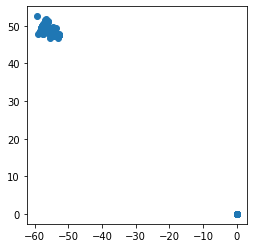

In [10]:
st_df.plot()

## Study location and segments relationship
Find the closest segment to each study

<AxesSubplot:>

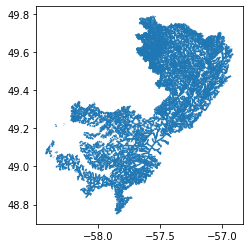

In [6]:
fl_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HN_NLFLOW_1.shp')
fl_df.plot()

In [39]:
# the data from open canada is 3d meaning it has a Z dimension


# the function is taken from this code snippet then modified for Linestring
# https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    Edited by Javad:  changes Poly to Linestring and used xy attribute, added else 
    '''
    new_geo = []
    for p in geometry:
#         print(p.has_z)
        if p.has_z:
            if p.geom_type == 'LineString':
                lines = [xy[:2] for xy in list(p.xy)]
                new_p = LineString(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
            elif p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            new_geo.append(p) # to handle if it is already a 2d
            
    return new_geo



Data from open Canada is 3d, i.e. has a Z component. convert to 2d:

In [ ]:
fl_df.geometry = convert_3D_2D(fl_df.geometry)

In [9]:
# a function for finding the closest point:

def ckdnearest_line(gdfA, gdfB, gdfB_cols=['name']):
    """ A is point and B is Linestring """
    # resetting the index of gdfA and gdfB here.
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf



## Creating segment ID
As the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [16]:
fl_df['row_index'] = fl_df.index
fl_df['row_index'] = fl_df['row_index'].astype('str')
fl_df['segment_id'] = fl_df['DATASETNAM'] + "-" + fl_df.row_index

In [17]:
# columns to keep from segment dataframe:
fl_cols = ['segment_id'] 
st_fl_nearest_df = ckdnearest_line( st_df, fl_df, fl_cols)

In [19]:
st_fl_nearest_df


,Unnamed: 0,Type/Type,Study/Etude,StudyDescription/Descriptiondeletude,StudyPurpose/Objectifdeletude,Authority/Autorite,Province/Province,Ecoregion/Ecoregion,EcoregionNumber/Numerodelecoregion,Site/Site,...,CWSSD_ID,CWSSD_Basin,StreamOrder/Ordreducoursdeau,ENVIRODATCode/Codedenvirodat,JulianDay/JourJulien,Year/Annee,SiteDescription/Descriptiondusite,geometry,segment_id,dist
0,0,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Southwestern Newfoundland,109,ATLCBNL-01,...,02Y02,Humber,2.0,NF02YJ0034,271,2009,"West of Grand Lake, down logging road off highway",POINT (-58.15167 48.68944),02YL000-3190,105.609944
1,1,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Southwestern Newfoundland,109,ATLCBNL-02,...,02Y01,Port au Port Bay,2.0,NF02YJ0035,271,2009,SW of Pinchgurt Lake (at bridge). Off logging/...,POINT (-58.02861 48.78750),02YL000-3190,105.706623
2,2,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Long Range Mountains,108,ATLCBNL-03,...,02Y03,Bonne Bay,2.0,NF02YH0066,271,2009,"West o River, access via sandpit",POINT (-57.73306 49.40361),02YL000-3190,106.320009
3,3,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Long Range Mountains,108,ATLCBNL-04,...,02Y04,Portland Creek Pond,1.0,NF02YE0062,272,2009,South-East of Greavett Brook,POINT (-57.57194 50.09083),02YL000-5305,106.331835
4,4,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Long Range Mountains,108,ATLCBNL-05,...,02Y04,Portland Creek Pond,1.0,NF02YE0061,272,2009,South West of Bowing Brook,POINT (-57.49528 50.27361),02YL000-5305,106.257636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,345,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,YPB01,...,02Y18,Southern and Eastern Bonavista Bay,1.0,NF02YS0108,298,2010,Yudle Pond Brook,POINT (-54.03028 48.43611),02YL000-5305,102.782217
346,346,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,YPB01,...,02Y18,Southern and Eastern Bonavista Bay,1.0,NF02YS0108,294,2012,NaN,POINT (-54.03028 48.43611),02YL000-5305,102.782217
347,347,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,YPB01,...,02Y18,Southern and Eastern Bonavista Bay,1.0,NF02YS0108,293,2014,NaN,POINT (-53.91528 48.62444),02YL000-5305,102.666812
348,348,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,YPB01,...,02Y18,Southern and Eastern Bonavista Bay,1.0,NF02YS0108,294,2016,NaN,POINT (-54.00000 48.00000),02YL000-5305,102.754204


Study points are matched with the closest segments to them. Segments are identified by segment_id. The distances between the study locations and the closest segment is stored in the `dist` column.

<AxesSubplot:>

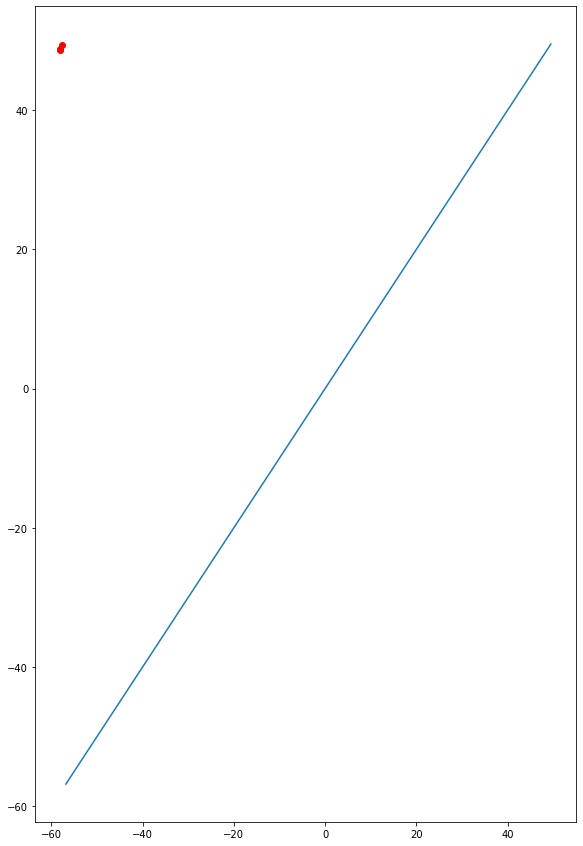

In [22]:
# plot study and segment

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df[fl_df['segment_id'] == '02YL000-3190'].plot(ax=ax)
st_fl_nearest_df.iloc[0:3,:].plot(color='red', ax= ax)

## Save in two formats:
- CSV for database import
- gpkg or shp for keeping the geometry feature intact

In [23]:
st_fl_nearest_df.to_csv('study_to_segments.csv')

In [24]:
st_fl_nearest_df.to_file("study_to_segments.shp")

<ipython-input-24-801337ef5c4b>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  st_fl_nearest_df.to_file("study_to_segments.shp")


## Study to water body connection:
Repeat the same process for water bodies dataset.

In [26]:
wb_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HD_WATERBODY_2.shp')

In [29]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,LAKEID_2,RIVID_1,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09..."
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73..."
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53..."
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54..."
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21..."


## Creating water body ID
Similar to segments, as the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [31]:
wb_df['row_index'] = wb_df.index
wb_df['row_index'] = wb_df['row_index'].astype('str')
wb_df['waterbody_id'] = wb_df['DATASETNAM'] + "-" + wb_df.row_index

In [34]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry,row_index,segment_id,waterbody_id
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09...",0,02YL000-0,02YL000-0
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73...",1,02YL000-1,02YL000-1
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53...",2,02YL000-2,02YL000-2
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54...",3,02YL000-3,02YL000-3
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21...",4,02YL000-4,02YL000-4


In [37]:

def ckdnearest_poly(gdfA, gdfB, gdfB_cols):
    """ A is point and B is Polygon """
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.exterior]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf



In [40]:
# same as segment, water body data from open canada needs to be 2d
wb_df.geometry = convert_3D_2D(wb_df.geometry) 

In [43]:
# columns to keep from waterbody dataframe:
wb_cols = ['waterbody_id'] 
st_wb_nearest_df = ckdnearest_poly(st_df, wb_df, wb_cols)

In [44]:
st_wb_nearest_df

,Unnamed: 0,Type/Type,Study/Etude,StudyDescription/Descriptiondeletude,StudyPurpose/Objectifdeletude,Authority/Autorite,Province/Province,Ecoregion/Ecoregion,EcoregionNumber/Numerodelecoregion,Site/Site,...,CWSSD_ID,CWSSD_Basin,StreamOrder/Ordreducoursdeau,ENVIRODATCode/Codedenvirodat,JulianDay/JourJulien,Year/Annee,SiteDescription/Descriptiondusite,geometry,waterbody_id,dist
0,0,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Southwestern Newfoundland,109,ATLCBNL-01,...,02Y02,Humber,2.0,NF02YJ0034,271,2009,"West of Grand Lake, down logging road off highway",POINT (-58.15167 48.68944),02YL000-5765,0.156204
1,1,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Southwestern Newfoundland,109,ATLCBNL-02,...,02Y01,Port au Port Bay,2.0,NF02YJ0035,271,2009,SW of Pinchgurt Lake (at bridge). Off logging/...,POINT (-58.02861 48.78750),02YL000-275,0.068823
2,2,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Long Range Mountains,108,ATLCBNL-03,...,02Y03,Bonne Bay,2.0,NF02YH0066,271,2009,"West o River, access via sandpit",POINT (-57.73306 49.40361),02YL000-1,0.086942
3,3,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Long Range Mountains,108,ATLCBNL-04,...,02Y04,Portland Creek Pond,1.0,NF02YE0062,272,2009,South-East of Greavett Brook,POINT (-57.57194 50.09083),02YL000-2491,0.304491
4,4,River,Atlantic CABIN,Sites collected by Environment Canada Atlantic...,Atlantic Canada sites collected by Environment...,Federal,NL,Long Range Mountains,108,ATLCBNL-05,...,02Y04,Portland Creek Pond,1.0,NF02YE0061,272,2009,South West of Bowing Brook,POINT (-57.49528 50.27361),02YL000-4530,0.488932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,345,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,YPB01,...,02Y18,Southern and Eastern Bonavista Bay,1.0,NF02YS0108,298,2010,Yudle Pond Brook,POINT (-54.03028 48.43611),02YL000-3571,3.081296
346,346,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,YPB01,...,02Y18,Southern and Eastern Bonavista Bay,1.0,NF02YS0108,294,2012,NaN,POINT (-54.03028 48.43611),02YL000-3571,3.081296
347,347,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,YPB01,...,02Y18,Southern and Eastern Bonavista Bay,1.0,NF02YS0108,293,2014,NaN,POINT (-53.91528 48.62444),02YL000-3571,3.133652
348,348,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,YPB01,...,02Y18,Southern and Eastern Bonavista Bay,1.0,NF02YS0108,294,2016,NaN,POINT (-54.00000 48.00000),02YL000-3571,3.281128


## Save in two formats:
- CSV for database import
- gpkg or shp for keeping the geometry feature intact

In [45]:
st_wb_nearest_df.to_csv('study_to_waterbody.csv')

In [46]:
st_wb_nearest_df.to_file("study_to_waterbody.shp")

<ipython-input-46-53778ef57edc>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  st_wb_nearest_df.to_file("study_to_waterbody.shp")
